# 神经网络分类模型

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)

# 打印版本信息
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.3
sklearn 1.6.1
torch 2.6.0+cpu
cpu


## 数据准备

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms


# 定义数据集的变换
# 这里没有做任何变换，只是为了展示数据集的格式
transform = transforms.Compose([
])
# fashion_mnist图像分类数据集，衣服分类，60000张训练图片，10000张测试图片
# transform的作用是对图像进行预处理，比如裁剪、旋转、缩放等
train_ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_ds = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

# torchvision 数据集里没有提供训练集和验证集的划分
# 当然也可以用 torch.utils.data.Dataset 实现人为划分

100%|██████████| 26.4M/26.4M [00:08<00:00, 3.15MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 112kB/s]
100%|██████████| 4.42M/4.42M [00:02<00:00, 1.48MB/s]
100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


In [3]:
# 通过id取数据，取到的是一个元祖,是第一个样本,在训练时，把特征和标签分开
img, label = train_ds[0]

In [4]:
# 显示图片
def show_img_content(img):
    from PIL import Image

    # 打开一个图像文件
    # img = Image.open(img)


    print("图像大小:", img.size)
    print("图像模式:", img.mode)


    # 如果图像是单通道的，比如灰度图，你可以这样获取像素值列表：
    if img.mode == 'L':
        pixel_values = list(img.getdata())
        print(pixel_values)
show_img_content(img) # 显示图片

图像大小: (28, 28)
图像模式: L
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 13, 73, 0, 0, 1, 4, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 36, 136, 127, 62, 54, 0, 0, 0, 1, 3, 4, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 102, 204, 176, 134, 144, 123, 23, 0, 0, 0, 0, 12, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 155, 236, 207, 178, 107, 156, 161, 109, 64, 23, 77, 130, 72, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 69, 207, 223, 218, 216, 216, 163, 127, 121, 122, 146, 141, 88, 172, 66, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 200, 232, 232, 233, 229, 223, 223, 215, 213, 164, 127, 123, 196, 229, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 183, 225, 216, 223, 228, 235, 227, 224, 222, 224, 221, 223, 245, 173, 0, 0, 0, 

# 为训练做准备

In [5]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

mean=0.2860
std=0.3205

# 定义数据集的变换
# ToTensor()将图像数据转换为张量，Normalize()对图像进行标准化
transform = transforms.Compose([
    transforms.ToTensor(), # 转换为tensor，进行归一化
    transforms.Normalize(mean, std) # 标准化，mean和std是数据集的均值和方差
])
# fashion_mnist图像分类数据集，衣服分类，60000张训练图片，10000张测试图片
train_ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_ds = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

In [6]:
img, label = train_ds[0]
img.shape  #img这时是一个tensor，shape=(1, 28, 28)

torch.Size([1, 28, 28])

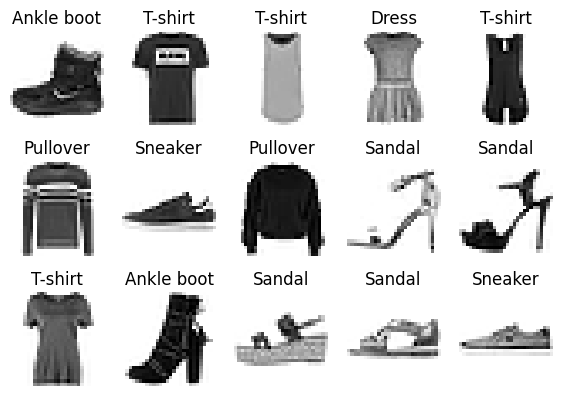

In [7]:
def show_imgs(n_rows, n_cols, train_ds, class_names):
    assert n_rows * n_cols < len(train_ds)  #确保打印的图片小于总样本数
    plt.figure(figsize = (n_cols * 1.4, n_rows * 1.6))  #宽1.4高1.6，宽，高
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col  # 计算索引，从0开始
            plt.subplot(n_rows, n_cols, index+1)#因为从1开始
            img_arr, label = train_ds[index]
            img_arr = np.transpose(img_arr, (1, 2, 0))  # 通道换到最后一维
            plt.imshow(img_arr, cmap="binary",
                       interpolation = 'nearest')#interpolation='nearest'是临近插值
            plt.axis('off')#去除坐标系
            plt.title(class_names[label]) # 显示类别名称
    plt.show()
    
    

#已知的图片类别
# lables在这个路径https://github.com/zalandoresearch/fashion-mnist
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker',
               'Bag', 'Ankle boot'] #0-9分别代表的类别
#只是打印了前15个样本
show_imgs(3, 5, train_ds, class_names)


In [11]:
# 从数据集到dataloader
# 作用是将数据集分批加载到内存中，以便模型训练时可以批量处理数据
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True) #batch_size分批，shuffle洗牌
# val_loader是验证集的loader
val_loader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)

在PyTorch中，`DataLoader`是一个迭代器，它封装了数据的加载和预处理过程，使得在训练机器学习模型时可以方便地批量加载数据。`DataLoader`主要负责以下几个方面：

1. **批量加载数据**：`DataLoader`可以将数据集（Dataset）切分为更小的批次（batch），每次迭代提供一小批量数据，而不是单个数据点。这有助于模型学习数据中的统计依赖性，并且可以更高效地利用GPU等硬件的并行计算能力。

2. **数据打乱**：默认情况下，`DataLoader`会在每个epoch（训练周期）开始时打乱数据的顺序。这有助于模型训练时避免陷入局部最优解，并且可以提高模型的泛化能力。

3. **多线程数据加载**：`DataLoader`支持多线程（通过参数`num_workers`）来并行地加载数据，这可以显著减少训练过程中的等待时间，尤其是在处理大规模数据集时。

4. **数据预处理**：`DataLoader`可以与`transforms`结合使用，对加载的数据进行预处理，如归一化、标准化、数据增强等操作。

5. **内存管理**：`DataLoader`负责管理数据的内存使用，确保在训练过程中不会耗尽内存资源。

6. **易用性**：`DataLoader`提供了一个简单的接口，可以很容易地集成到训练循环中。



## 定义模型

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__() # 继承父类的初始化方法，子类有父类的属性
        self.flatten = nn.Flatten()  # 展平层
        # Sequential容器，将多个层组合成一个网络，并自动按照顺序执行
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 300),  # in_features=784, out_features=300, 784是输入特征数，300是输出特征数
            # 激活函数的作用是将输入信号转换为输出信号，使得神经网络可以学习非线性关系
            nn.ReLU(), # 激活函数
            nn.Linear(300, 100),#隐藏层神经元数100
            nn.ReLU(), # 激活函数
            nn.Linear(100, 10),#输出层神经元数10 
        )

    def forward(self, x): # 前向计算，前向传播
        # x.shape [batch size, 1, 28, 28],1是通道数
        x = self.flatten(x)  
        # print(f'x.shape--{x.shape}')
        # 展平后 x.shape [batch size, 784]
        logits = self.linear_relu_stack(x)
        # logits.shape [batch size, 10]
        return logits #没有经过softmax,称为logits
    
model = NeuralNetwork()

In [14]:
# 查看模型运算的tensor尺寸
x = torch.randn(32, 1, 28, 28)
print(x.shape)
logits = model(x)
print(logits.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


In [15]:
model.state_dict()  # 这种方法用于保存模型参数，看能看见参数属于模型的哪一部分

OrderedDict([('linear_relu_stack.0.weight',
              tensor([[ 0.0098, -0.0007,  0.0019,  ..., -0.0091, -0.0109, -0.0216],
                      [-0.0142, -0.0090,  0.0344,  ...,  0.0210,  0.0114,  0.0264],
                      [ 0.0354, -0.0086, -0.0172,  ..., -0.0127,  0.0343,  0.0021],
                      ...,
                      [-0.0274, -0.0329,  0.0163,  ...,  0.0173,  0.0156,  0.0237],
                      [ 0.0008, -0.0014, -0.0207,  ..., -0.0114,  0.0286, -0.0232],
                      [ 0.0297,  0.0322, -0.0315,  ..., -0.0050,  0.0337,  0.0178]])),
             ('linear_relu_stack.0.bias',
              tensor([-2.2464e-02, -2.4523e-02,  3.0475e-02,  2.6549e-02,  2.2809e-02,
                       6.7538e-03,  1.2821e-03, -6.4724e-04, -3.0358e-02,  7.0793e-03,
                      -1.8129e-02, -5.1652e-03, -1.3377e-02,  3.1414e-02,  1.7449e-02,
                       3.5265e-03, -3.2258e-02,  7.1981e-03, -8.1219e-03, -1.9475e-02,
                      -8.1172e-0

## 训练

pytorch的训练需要自行实现，包括
1. 定义损失函数
2. 定义优化器
3. 定义训练步
4. 训练

In [16]:
# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss() #内部先做softmax，然后计算交叉熵
# 2. 定义优化器 采用SGD
# Optimizers specified in the torch.optim package,随机梯度下降
# 学习率lr=0.01
# 动量momentum=0.9
# model.parameters()返回模型的所有可学习参数
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [17]:
from sklearn.metrics import accuracy_score

@torch.no_grad() # 装饰器，禁止反向传播，节省内存
# evaluating的作用是计算验证集的损失和准确率
def evaluating(model, dataloader, loss_fct):
    loss_list = [] # 记录损失
    pred_list = [] # 记录预测
    label_list = [] # 记录标签
    for datas, labels in dataloader:#10000/32=312
        datas = datas.to(device) # 转到GPU
        labels = labels.to(device) # 转到GPU
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)         # 验证集损失,loss尺寸是一个数值
        loss_list.append(loss.item()) # 记录损失,item是把tensor转换为数值
        
        preds = logits.argmax(axis=-1)    # 验证集预测,argmax返回最大值索引
        # print(preds)
        pred_list.extend(preds.cpu().numpy().tolist())#将PyTorch张量转换为NumPy数组。只有当张量在CPU上时，这个转换才是合法的
        # print(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())
        
    acc = accuracy_score(label_list, pred_list) # 计算准确率
    return np.mean(loss_list), acc


In [18]:
# 训练
def training(model, train_loader, val_loader, epoch, loss_fct, optimizer, eval_step=500):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    #tqdm是一个进度条库
    with tqdm(total=epoch * len(train_loader)) as pbar: # 进度条 1875*20,60000/32=1875
        for epoch_id in range(epoch): # 训练epoch次
            # training
            for datas, labels in train_loader: #执行次数是60000/32=1875
                datas = datas.to(device) #datas尺寸是[batch_size,1,28,28]
                labels = labels.to(device) #labels尺寸是[batch_size]
                # 梯度清空的作用是防止梯度累加，导致训练不收敛
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传，loss.backward()会计算梯度，loss对模型参数求导
                loss.backward()
                # 调整优化器，包括学习率的变动等,优化器的学习率会随着训练的进行而减小，更新w,b
                optimizer.step() #梯度是计算并存储在模型参数的 .grad 属性中，优化器使用这些存储的梯度来更新模型参数

                preds = logits.argmax(axis=-1) # 训练集预测
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())   # 计算准确率，numpy可以
                loss = loss.cpu().item() # 损失转到CPU，item()取值,一个数值
                # record
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                }) # 记录训练集信息，每一步的损失，准确率，步数
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval() # 进入评估模式
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train() # 进入训练模式

                # udate step
                global_step += 1 # 全局步数加1
                pbar.update(1) # 更新进度条
                pbar.set_postfix({"epoch": epoch_id}) # 设置进度条显示信息
        
    return record_dict
        

epoch = 20 #改为40
model = model.to(device)
record = training(model, train_loader, val_loader, epoch, loss_fct, optimizer, eval_step=1000)

  0%|          | 0/37500 [00:00<?, ?it/s]

step
0        0.12500
1000     0.87500
2000     0.87500
3000     0.78125
4000     0.78125
5000     0.78125
6000     0.87500
7000     0.90625
8000     0.93750
9000     0.90625
10000    0.90625
11000    0.84375
12000    0.93750
13000    0.96875
14000    0.87500
15000    0.81250
16000    0.90625
17000    1.00000
18000    0.90625
19000    0.90625
20000    0.93750
21000    0.87500
22000    0.96875
23000    0.84375
24000    0.90625
25000    0.93750
26000    0.96875
27000    0.90625
28000    0.90625
29000    0.87500
30000    0.96875
31000    0.96875
32000    1.00000
33000    0.93750
34000    0.93750
35000    0.96875
36000    0.96875
37000    0.93750
Name: acc, dtype: float64
step
0        0.1627
1000     0.7973
2000     0.8244
3000     0.8368
4000     0.8449
5000     0.8502
6000     0.8555
7000     0.8582
8000     0.8613
9000     0.8476
10000    0.8591
11000    0.8691
12000    0.8664
13000    0.8712
14000    0.8678
15000    0.8696
16000    0.8751
17000    0.8751
18000    0.8777
19000    0.880

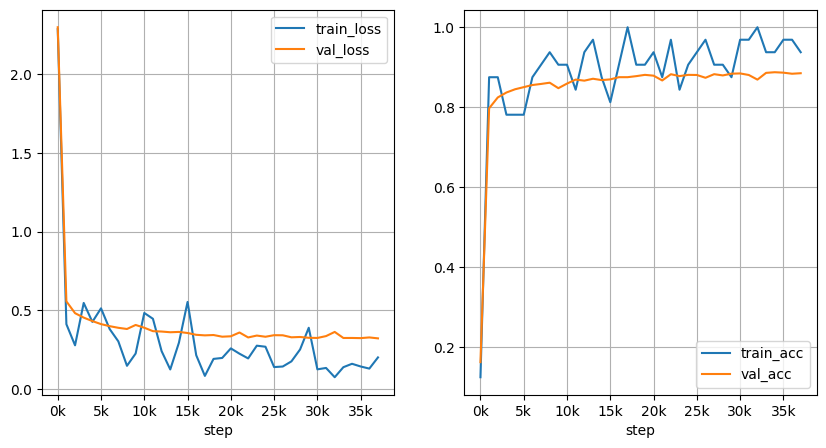

In [19]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=1000):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")
    last_step = train_df.index[-1] # 最后一步的步数
    # print(train_df.columns)
    print(train_df['acc'])
    print(val_df['acc'])
    # plot
    fig_num = len(train_df.columns) # 画几张图,分别是损失和准确率
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        # print(train_df[item].values)
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid() # 显示网格
        axs[idx].legend() # 显示图例
        axs[idx].set_xticks(range(0, train_df.index[-1], 5000)) # 设置x轴刻度
        axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, last_step, 5000))) # 设置x轴标签
        axs[idx].set_xlabel("step")
    
    plt.show()

plot_learning_curves(record)  #横坐标是 steps

## 评估

In [20]:
# dataload for evaluating

model.eval() # 进入评估模式
loss, acc = evaluating(model, val_loader, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.3288
accuracy: 0.8849
